In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize = (9,3)
else:
    figsize = (13,4)


from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

# Load data
data_folder = '/app/data/nab'
file_name = 'realKnownCause/nyc_taxi.csv'
data, labels, windows = nab.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Build a cost model
cmodel = nab.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Compute the maximum over the training set
trmax = data[data.index < train_end]['value'].max()
# Normalize
data['value'] = data['value'] / trmax
# Separate the training data
data_tr = data[data.index < train_end]

# Apply a sliding window
wlen = 48
wdata = nab.sliding_window_1D(data, wlen=wlen)


# ------------------------------------------------------------------
# For a later comparison: train a KDE model
# ------------------------------------------------------------------

# Compute the bandhwidth
q1 = data_tr['value'].quantile(0.25)
q3 = data_tr['value'].quantile(0.75)
sigma = data_tr['value'].std()
m =  len(data_tr)
h = 0.9 * min(sigma, (q3-q1) / 1.34) * m**(-0.2)
print(f'KDE bandwidth: {h}')

# Build and fit a density estimator
print('Fitting a KDE estimator')
kde = KernelDensity(kernel='gaussian', bandwidth=h)
kde.fit(data_tr);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
KDE bandwidth: 0.03476971577055476
Fitting a KDE estimator


# Anomaly Detection via Autoregression

## Drawbacks

**We managed to use KDE for anomaly detection to a good effect**

But there are some drawbacks:

* Training was pretty fast (except for the bandwidth optimization)
* ...but obtaining predictions was _a bit slow_

**Latency _may be an issue_:**

* In our case, time steps are 30 minutes long
* ...Which gives ample time to make predictions
* In other problems, there are strict latency constraints
  - E.g. graceful thermal throttling of a multi-core CPU
  - E.g. speed control in an industrial pump

**What if KDE turns up to be too slow?**

## Anomaly Detection via Autoregression

**Let us see an alternative approach for anomaly detection:**

The main idea is to build an _autoregressor_, say $f(x)$:

* Autoregressor = a predictor for the next step in the time series
* We can then use the _prediction error as an alarm signal_

$$
|f(x) - y| \geq \theta
$$

**Why doing that?**

* This trick allows us to use _any regression approach_ for anomaly detection
* E.g. Linear Regression, (Ensembles of) Decision Trees, Neural Networks...

**As usual, we will make an attempt with the simplest possible approach:**

I.e. we are going to use _Linear Regression_

## Linear Regression

**A few known things about Linear Regression**

**1)** It's a _supervised_ learning approach (training set = $\hat{x}$, target = $\hat{y}$)


**2)** The goal is typically to fit a _linear combination_ of the input features, i.e.:

$$
f(x, w) = w_0 + \sum_{j=1}^n w_i x_i
$$

* $w$ is a vector of $n+1$ weights, $w_0$ is used a constant and it's called _intercept_
* If the signal to be predicted has 0-mean, $w_0$ can be omitted


**3)** Training is done via the _Least Squares method_:


$$
\text{argmin}_w \|f(\hat{x}, w) - \hat{y}\|_2^2
$$

## Linear Regression

**A few less-known things about Linear Regression**


**1)** The least squares method _can be optimally solved_ in polynomial time

* It's a convex, unconstrained, numerical optimization problem
* Solving a linear systems of equations yields an _optimal_ solution
* Gradient descent gets arbitrarily close


**2)** The least squares method _works for "non-linear" functions_

* In fact, you can fit any function in the form:
$$
f(x, w) = w_0 + \sum_{j=1}^n w_i K(x)
$$
* $K$ is called in this case a basis function and can be non-linear

## Linear Regression

**A few less-known things about Linear Regression**

In the least squares method we minimize:

$$
\sum_{i=1}^m (f(\hat{x}_i, w) - \hat{y}_i)^2
$$

Multiplying everything for a scalar does not change the optimal point:

$$
\sum_{i=1}^m \frac{1}{2}(f(\hat{x}_i, w) - \hat{y}_i)^2
$$

## Linear Regression

**A few less-known things about Linear Regression**

Then, with a few manipulations we get:

$$
\sum_{i=1}^m \log e^{\frac{1}{2}(f(\hat{x}_i, w) - \hat{y}_i)^2}
$$

...And then:

$$
\log \left(\prod_{i=1}^m e^{\frac{1}{2}(f(\hat{x}_i, w) - \hat{y}_i)^2} \right)
$$

## Linear Regression

**A few less-known things about Linear Regression**

Once, again we make a few modifications that do not change the optimal solution:

$$
\log \left(\prod_{i=1}^m \frac{1}{\sigma \sqrt{2\pi}} e^{\left(\frac{f(\hat{x}_i, w) - \hat{y}_i}{\sigma}\right)^2} \right)
$$

* Where $\sigma$ is _constant_

This is the log likelihood of $\hat{y}$, assuming a normal distribution!


**3)** So the predictions can be interpreted as solutions of $\text{argmax}_y P(\hat{y} \mid {\bf x})$

* I.e. the most likely values, assuming that the target
* ...Follows a _a Normal distribution_ with a _fixed variance_

This is an important (often) _hidden assumption_ of Linear Regression

## Linear Regression

**It does not hold only for Linear Regression**

Given an observation $x$:

> **Any regressor f(x) trained for a MSE loss outputs a _conditional Maximum A Posteriori (MAP)_, with the assumption that the target has fixed variance**

* MAP the most likely value of an estimated probability distribution
* The distribution is conditional, since $x$ is observed
* The fixed variance assumption is called homoscedasticity
* If the data is not really homoscedastic, the regressor will work less well


## Preparing The  Dataset

**Before using Linear Regression, we need to build the target vector**

In [3]:
wdata_out = data.iloc[wlen:]['value']
wdata_out.head()

timestamp
2014-07-02 00:00:00    0.440194
2014-07-02 00:30:00    0.327429
2014-07-02 01:00:00    0.249267
2014-07-02 01:30:00    0.194811
2014-07-02 02:00:00    0.158694
Name: value, dtype: float64

* The last known output will be at the end of the series
* So we need to remove the last row from our sliding window dataset

In [4]:
wdata_in = wdata.iloc[:-1]

## Fitting the Linear Model

**Next, we need to separate the training set:**

In [5]:
wdata_in_tr = wdata_in[wdata_in.index < train_end]
wdata_out_tr = wdata_out[wdata_out.index <= train_end] # Notice the "<=" sign

* `wdata_in` and `wdata_out` have different indices (hence the "<=" sign)

**Then, we can train our predictor:**

In [6]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(wdata_in_tr, wdata_out_tr);

* Predictions are associated to the `wdata_out` index

## Obtaining the Predictions


**We can now obtain the predictions:**

In [7]:
%time pred_out = reg.predict(wdata_in)
pred_out = pd.Series(index=wdata_out.index, data=pred_out)

CPU times: user 5.12 ms, sys: 3.09 ms, total: 8.21 ms
Wall time: 2.83 ms


* The process is now very fast!
* Time can be measures via the `%time` ipython magic

**For comparison, let us see the time for KDE (the _univariate_ estimator)**

In [8]:
%time ldens = kde.score_samples(data)
signal = pd.Series(index=data.index, data=-ldens)

CPU times: user 2.92 s, sys: 192 µs, total: 2.92 s
Wall time: 2.93 s


## Prediction  Quality

**Let us have a look at the prediction quality:**

R2: 0.979


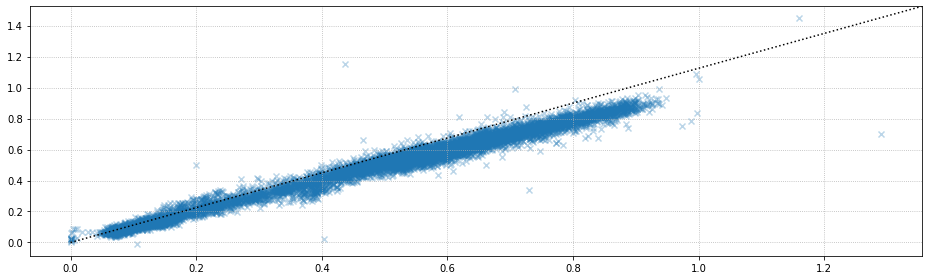

In [10]:
nab.plot_prediction_scatter(wdata_out, pred_out, figsize=figsize)
print(f'R2: {r2_score(wdata_out, pred_out):.3f}')

## Alarm Signal

**We now just need to compute the errors to obtain our signal**

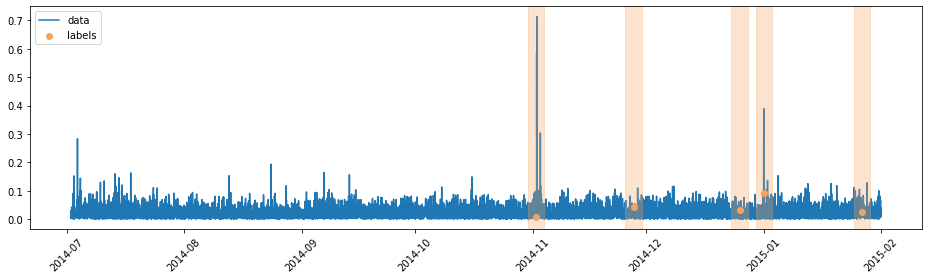

In [12]:
err = wdata_out - pred_out
signal = np.abs(err)
nab.plot_series(signal, labels, windows, figsize=figsize)

* It does not seem to be particularly good

## Threshold Optimization

**We can proceed as usual (threshold optimization and evaluation)**

In [13]:
thr_range = np.linspace(0.1, 1, 100)
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr:.3f}, corresponding cost: {best_cost}')

Best threshold: 0.291, corresponding cost: 15


Over all the dataset

In [14]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 35


## Considerations

**Some considerations and take-home messages**

An alternative way to perform Anomaly Detection:

* Train an autoregressor and use the (absolute) error as an alarm signal
* You can use any regression approach
* Typicallly faster signal generations

We are not restricted to absolute errors:

* We can use other functions, with different results
* A better interpretation will come in a few lectures

The least squares method:

* Assumes the predictions is _Normally distributed_ with _fixed_ variance
* The fixed variance is an important limitation
